<a href="https://colab.research.google.com/github/DejiangZ/Heart-Rate-Monitoring_PPG/blob/master/Lab12_Sensor_Data_and_Deep_Learning_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sensor Data and Deep Learning 3: Convolution Neural Network and Recurrent Neural Network
*This material is a joint work of TAs from IC Lab at KAIST, including Woohyeok  Choi, Soowon Kang, Auk Kim, Inyeob Kim, Minhyung Kim, Hansoo Lee, Cheul Y. Park, and Eunji Park. This work is licensed under CC BY-SA 4.0.*


In [ ]:
%pip install numpy pandas tensorflow tensorflow-addons scikit-learn plotly

In [ ]:
import tensorflow as tf

tf.random.set_seed(42)

## Purpose of Today's Lab
* Getting *more and more familiar* with Keras programming interface.
* Building and evaluating a convolution neural network and recurrent neural network for human activity recognition (HAR).
* **IMPORTANT**: One homework (until May 23) and one nano-quiz (on May 19).

## Convolution Neural Network (CNN)


### Background

Throughout the previous two lectures, we have covered a regular neural network in which each input has a corresponding weight. While this architecture worked well, there are many weights we should optimize. Remember? We had to train about 280,000 parameters for just classifying 28x28 pixels of grayscale images! What if we want to classify HD images? We may need to train billions of parameters.

Instead of one-to-one mapping between inputs and weights, what if we can reduce the number of weights? Then, we may boost training speed, consume fewer resources/time, and mitigate overfitting if possible. But is it possible? Yeah, in the world of convolution neural networks, it is possible!

#### Convolution Layer

Literally, the core of the *convolution* neural network is *the convolution layer*. This layer converts local receptive field inputs into output filter maps via filters. What? Receptive field? Filter? Filter map? The CNN contains several unique concepts that seem difficult to understand. However, the example below may help you know them.


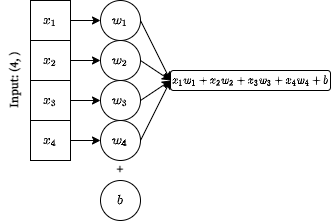


The figure above shows a typical layer architecture that we have covered. Each input has a corresponding weight, and thus the number of weights that we have to optimize is equal to the input size.

If we can reduce the number of weights by half, it may be feasible to handle large image inputs. Let's see the architecture below.


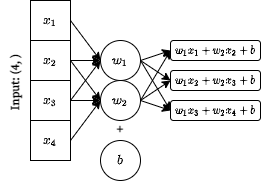


This architecture has only two weights, in which *some inputs share weights with other inputs*. In addition, it gives three outputs instead of a single output in the previous architecture. Likewise, we can reduce the number of parameters we should train. However, is it right to do? It is possible in the convolution neural network *if some inputs are related to other inputs*.


##### 1-D Convolution Layer

###### Simple Example: 1-D Input

Let's reorganize the previous architecture as below: 1-D convolution layer.

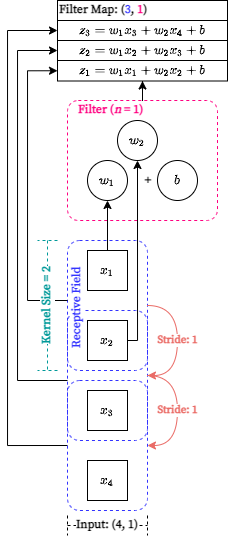

Let's suppose our input, $x_{t}$, is a heart rate value collected at time $t$. Then, $x_{t}$ and $x_{t+1}$ may be highly related because they are collected from the same data source (i.e., heart rate) and temporally close (i.e., $t$ and $t+1$). Therefore, we may think that some features can be extracted within $x_{t}$ and $x_{t+1}$, like feature extraction from a time window in the supervised learning lecture. Such a window is called *receptive field*, and the window size is called *kernel size* in the CNN. We can also *move* the window like a sliding window, called *stride* in the CNN. As a regular neural network, CNN calculates a weighted sum of inputs within the receptive field. A set of weights is called *filter*, and outputs are called *filter map* in the CNN.

Then, let's see how we implement a convolution layer in Keras. First, we will build the layer same as the figure above:
* Four 1-D inputs from the same source (i.e., 1 column and 4 rows) come into the layer:
```python
input_shape = (4,1)
```
* The receptive field includes 2 rows of inputs (and thus, the kernel size is 2):
```python
kernel_size = 2
```
* The receptive field slides by one row:
```python
strides = 1
```
* There is only a single filter:
```python
filters = 1
```

In [ ]:
from tensorflow import keras


model = keras.models.Sequential([
    keras.layers.Conv1D(
        input_shape=(4, 1), # 4 rows and 1 columns
        kernel_size=2, # the size of the window or the receptive field
        strides=1, # Sliding size
        filters=1, # The number of filters
    )
])

model.summary()

The output shape and the number of parameters in the model are exactly the same as the figure, right?

###### Generalized 1-D Convolution Layer

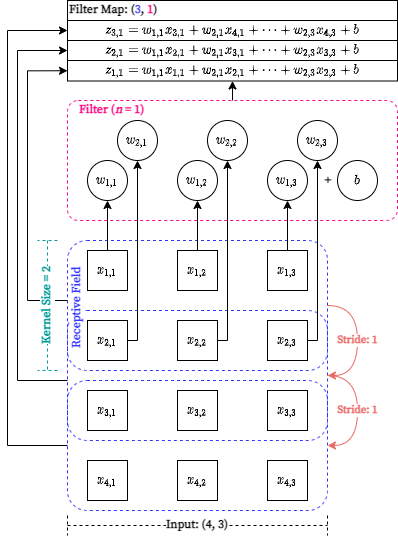

If you have multi-dimensional inputs, the receptive field of the 1-D convolution layer contains all dimensional inputs. For example, if you have four 3-D inputs above and the kernel size is 2, the 1-D convolution layer calculates a weighted sum of all inputs within two rows.


Let's check whether it is correct via the codes below.


In [ ]:
from tensorflow import keras


model = keras.models.Sequential([
    keras.layers.Conv1D(
        input_shape=(4, 3), # 4 rows and 3 columns
        kernel_size=2, # the size of the window or the receptive field
        strides=1, # Sliding size
        filters=1, # The number of filters
    )
])

model.summary()

The number of parameters is 7: 1 (# Filters) x 7 (2 kernel size x 3 columns + 1 bias)

In addition, we can consider multiple filters, as below.


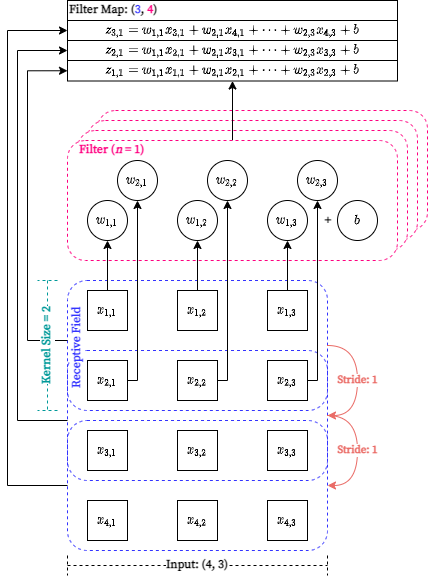

In [ ]:
from tensorflow import keras


model = keras.models.Sequential([
    keras.layers.Conv1D(
        input_shape=(4, 3), # 4 rows and 3 columns
        kernel_size=2, # the size of the window or the receptive field
        strides=1, # Sliding size
        filters=4, # The number of filters
    )
])

model.summary()

The number of parameters is 28: 4 (# Filters) x 7 (2 kernel size x 3 columns + 1 bias). In addition, you can see that *the output shape is changed: (3, **4**)*. The times that the receptive field can slide correspond to *the number of rows*, and the number of filters is equal to *the number of columns* in the output shape.

As such, the 1-D convolution layer can be used to handle *a time-series data*, in which there is a *temporal relationship* between data. For example, suppose acceleration values from 3 axes (i.e., x, y, and z) are collected every second, and you want to classify a current activity using accelerations collected for 4 seconds. Then, the convolution layer receives inputs composed of 4 rows (i.e., values for 4 seconds) and 3 columns (i.e., x, y, and z).

##### $n$-D Convolution Layer
We allowed the 1-D receptive field to slide row-wise because we suppose our input is time-series data. What about image data? As you know, in the image, each pixel may have a spatial relationship with nearby pixels. Therefore, we may need to slide *the 2-D receptive field row- and column-wise*. *2-D convolution layer* performs such operations. Of course, we can think about *3-D convolution layer* in which 3-D receptive fields move by row-, column-, and an orthogonal direction to both row and column.


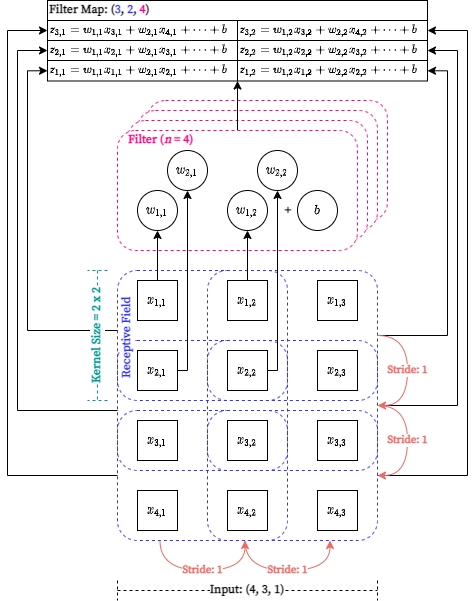

The example above shows how the 2-D convolution layer works. This layer has *2 x 2 kernel size* and *4 filters*. The receptive field slides by one step in a row- and column-wise directions.

Then, let's implement the layer above in Keras.

In [ ]:
from tensorflow import keras


model = keras.models.Sequential([
    keras.layers.Conv2D(
        input_shape=(4, 3, 1),
        kernel_size=(2, 2),
        strides=1,
        filters=4,
    )
])

model.summary()

The number of parameters is 20: 4 (# Filters) x 5 (2 x 2 kernel size x 1 channel + 1 bias)

We note that we need to define input shape as a tuple of three integers, *the number of rows, the number of columns, and a dimension that is orthogonal to rows and columns*. The last dimension is typically called the channel in the 2-D convolution layer.

In the previous example of the 1-D convolution layer, you defined an input shape as a tuple of the number of rows and the number of columns, like (4, 3). For each column (i.e., the last number of the shape), you perform convolution operations on 4 rows (i.e., the first number of the shape).

Now, let's see the 2-D convolution layer, like (4, 3, 1). For each channel (i.e., the last number of the shape), you perform convolution operations on 4x3 matrix (i.e., the first two numbers of the shape).

If you increase the number of channels:


In [ ]:
from tensorflow import keras


model = keras.models.Sequential([
    keras.layers.Conv2D(
        input_shape=(4, 3, 5),
        kernel_size=(2, 2),
        strides=1,
        filters=4
    )
])

model.summary()


The number of parameters is 20: 4 (# Filters) x 21 (2 x 2 kernel size x 5 channels + 1 bias)

##### Zero-Padding
Let's come back to the 1-D convolution layer.



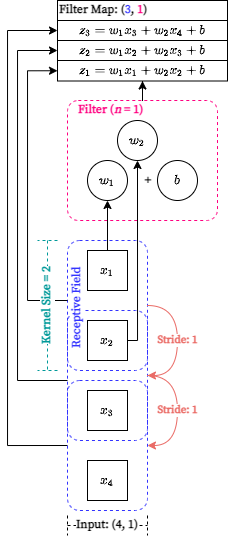그림


As shown above, our input dimension is reduced from 4 to 3 via the convolution layer. What if we use a larger kernel size, like 3 instead of 2?


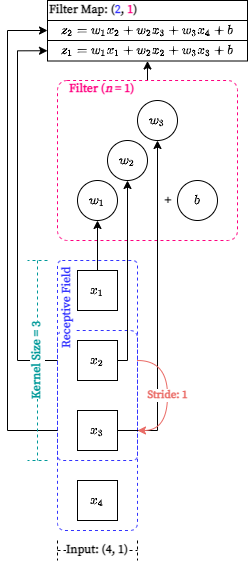


Yeah, we can get the smaller size of outputs. As such, an increase in the kernel size reduces the convolution output size. Is it good? Maybe not. If you stack multiple convolution layers, your inputs will become smaller and smaller, eventually disappearing. We do not want our input to go somewhere.


What if we increase strides from 1 to 2?

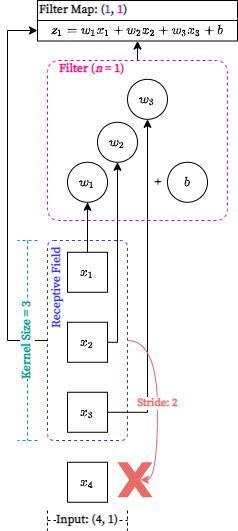

We can perform the first convolution operation, but there are insufficient inputs for the subsequent convolution. Therefore, we cannot perform convolution operations and will lose the information of such a receptive field. As we learned in the signal processing lecture, a solution for addressing these problems is *zero-padding* which puts some zeros at the start or end of inputs.

Let's see how zero padding can maintain an input size:

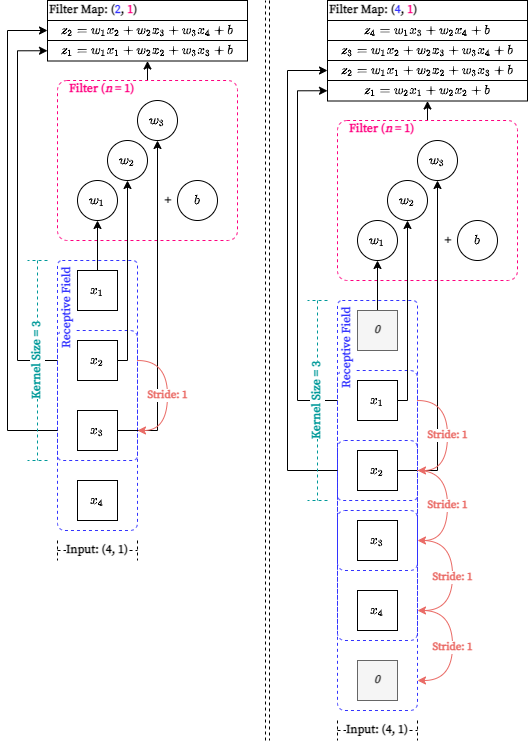

As shown above, we can get an output whose size is equal to the input size by padding zeros at the input's start and end.

What about a larger stride?


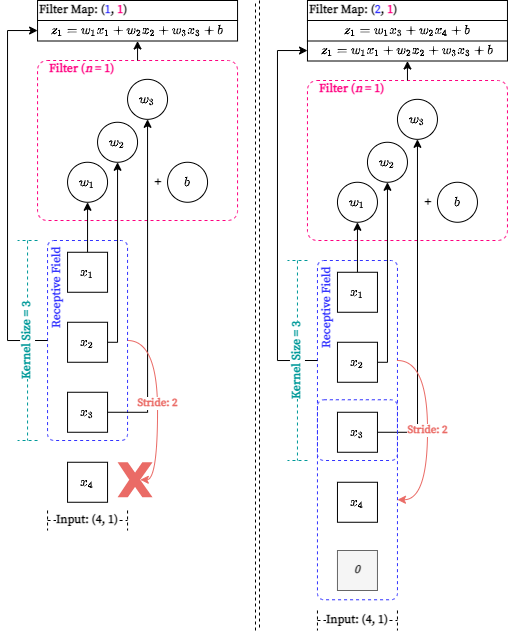

By putting a zero at the end of the input, the receptive field can slide two times so that $x_4$ is used to calculate a filter map.

Here is an equation for an output length of the convolution layer:
* Without zero-padding:
$$
\lfloor \frac{\text{input_length} + \text{strides} - \text{kernel_size}}{\text{strides}} \rfloor
$$

* With zero-padding:
$$
\lfloor \frac{\text{input_length} + \text{strides} - 1}{\text{strides}} \rfloor
$$

As shown in the equation, if the receptive field slides by one (i.e., strides = 1), you can get an output whose size is equal to the input size with zero padding.

Then, how can we implement zero-padding in Keras? You just need to set the argument, *padding*, as "*same*" (or, if you do not want zero-padding, you set "padding" as "valid").




In [ ]:
from tensorflow import keras


print('# W/O Zero padding')
print(
    keras.models.Sequential([
        keras.layers.Conv1D(
            input_shape=(4, 1),
            kernel_size=3,
            strides=1,
            filters=1,
            padding="valid" # w/o zero padding; this is a default value
        )
    ]).summary()
)

print('# W/ Zero padding')
print(
    keras.models.Sequential([
        keras.layers.Conv1D(
            input_shape=(4, 1),
            kernel_size=3,
            strides=1,
            filters=1,
            padding="same" # w/ zero padding; "same" means that the output length is "same" as the input length
        )
    ]).summary()
)


#### Pooling Layer
The convolution layer extracts important information considering the spatial or temporal relationship between data. However, the size of inputs remains large if we use zero-padding with one stride. The large input size corresponds to the large number of parameters we should optimize, and thus, we need a longer duration and more extensive resources for training the CNN.

The most obvious way to reduce the number of parameters is to shrink the input size. However, at the same time, we want to keep important information even if we reduce the input size. This is the role of the pooling layer.

The operations conducted in the pooling layer are simple: As similar to typical feature extraction, the pooling layer extracts statistics (e.g., mean, max, min) from a sliding window (i.e., the receptive field with strides). The popular operation for the pooling layer is to get the maximum (called *Max Pooling Layer*) or mean (called *Average Pooling Layer*) from inputs in a receptive field. Interestingly, the max-pooling layer works better in practice than the average pooling layer.


###### 1-D Pooling Layer

Let's see the example, 1-D pooling layer on 1-D input:


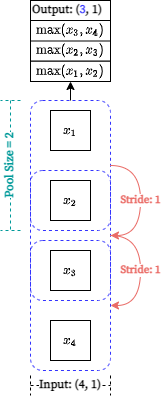

As shown above, the pooling layer has *pool size*, which is similar to the kernel size of the convolution layer, and *strides*, which acts the same as the convolution layer. However, the pooling layer does not have parameters that we should train via backpropagation because its outputs depend on the inputs' statistical distribution, not the loss function.

Then, let's implement the pooling layer in Keras.

In [ ]:
from tensorflow import keras


model = keras.models.Sequential([
    keras.layers.MaxPool1D(
        input_shape=(4, 1),
        pool_size=2,
        strides=1
    )
])

model.summary()

As shown above, there is no parameter we need to train.

Another example, a 1-D pooling layer on 3-D input with 2 strides, is as below:

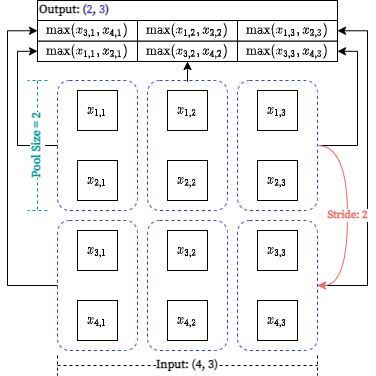

In [ ]:
from tensorflow import keras


model = keras.models.Sequential([
    keras.layers.MaxPool1D(
        input_shape=(4, 3),
        pool_size=2,
        strides=2
    )
])

model.summary()

Unlike the 1-D convolution layer, the 1-D pooling layer does not calculate a weighted sum of inputs based on filters, and thus, the output shape solely depends on the input shape.

###### $n$-D Pooling Layer
Of course, we can think 2-D pooling layer, as below:

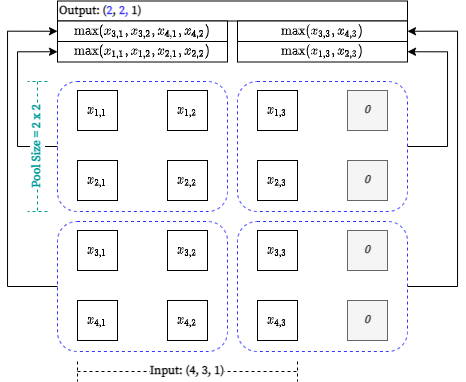

As shown above, the pooling layer also supports *zero-padding*.

In [ ]:
from tensorflow import keras


model = keras.models.Sequential([
    keras.layers.MaxPool2D(
        input_shape=(4, 3, 1),
        pool_size=2,
        strides=2,
        padding='same'
    )
])

model.summary()

Note that *the size of strides is equal to the pool_size* in the case of a typical CNN.


### Example of CNN Architecture: Fashion MNIST
Then, let's see the actual example of the CNN architecture for handling the Fashion MNIST dataset.

###### Preparation
First, we will prepare the Fashion MNIST dataset.


In [ ]:
from tensorflow import keras


(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0 # Rescaling from 0 - 255 to 0.0 - 1.0

X_train_1D, X_test_1D = X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)

print(X_train_1D.shape)
print(X_test_1D.shape)

Typically, the training of CNN is terribly slow because CNN has lots of matrix multiplication. Therefore, we need the help of special hardware that can well handle the matrix multiplication: the Graphics Processing Unit (GPU).

To use GPU in the Colab, you must first change a runtime type into the GPU: Runtime (in the menu bar) - Change Runtime Type - Hardware Accelerator - GPU.

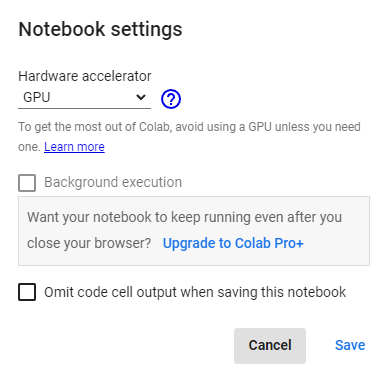

And then, check whether we have GPU:

In [ ]:
import tensorflow as tf


print(f'GPU found: {tf.test.gpu_device_name()}')

Tensorflow and Keras will *automatically* activate GPU usage for training if the GPU is found.

###### Deep Neural Network

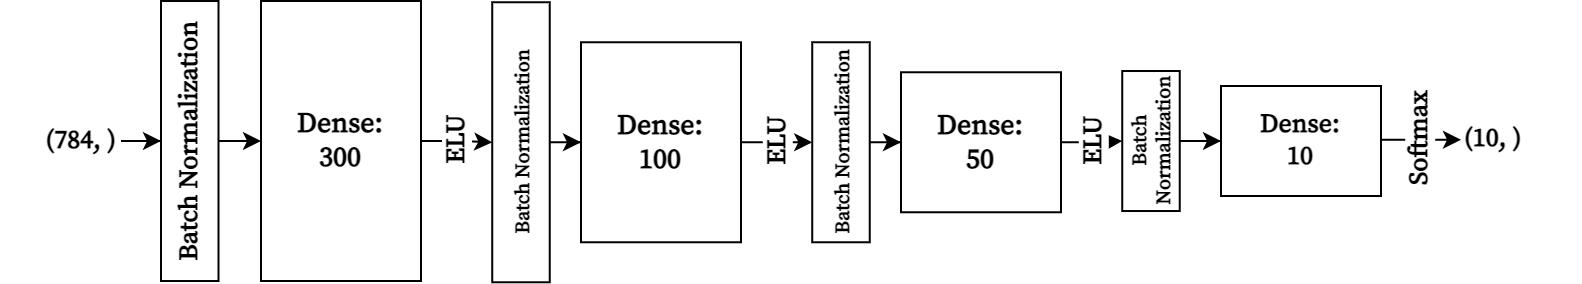

We will use the DNN model that we built in the previous lecture for performance comparisons.


In [ ]:
from tensorflow import keras


model_dnn = keras.models.Sequential([
    keras.layers.BatchNormalization(
        input_shape=(784, ),
    ),
    keras.layers.Dense(
        units = 300,
        activation=keras.activations.elu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(
        units = 100,
        activation=keras.activations.elu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(
        units = 50,
        activation=keras.activations.elu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(
        units = 10,
        activation=keras.activations.softmax,
        kernel_initializer=keras.initializers.GlorotUniform(seed=42),
    )
])

print(f'# Summary: \r\n{model_dnn.summary()}')

model_dnn.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[
            keras.metrics.SparseCategoricalAccuracy(),
    ]
)

model_dnn.fit(
    x=X_train_1D,
    y=y_train,
    batch_size=32,
    epochs=5,
)

model_dnn.evaluate(X_test_1D, y_test)

###### Convolution Neural Network

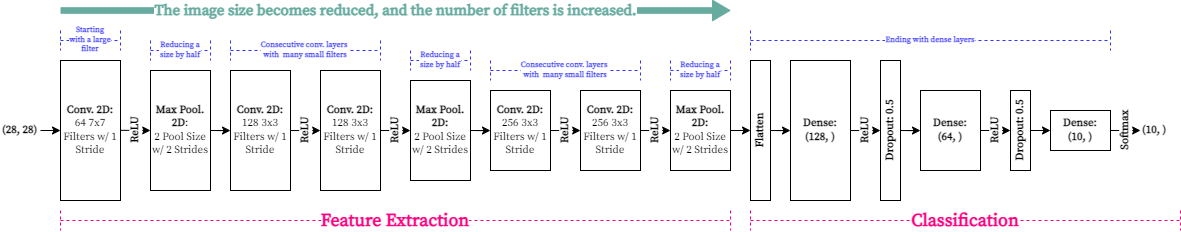

([Here](https://drive.google.com/file/d/15A_d1RWi27WTu9h-cqbnTI1X34z0ZVpI/view?usp=sharing) is the bigger image.)

As shown above, the CNN architecture typically:
* Starts with the small number of filters but the large kernel size
* Reduces the input size using the pooling layer
* Joins multiple convolution layers together
* Increase the number of filters as the input size is reduced and the network goes deeper
* Ends with fully connected layers

In [ ]:
from tensorflow import keras


model_cnn = keras.models.Sequential([
    keras.layers.Conv2D(
        input_shape = [28, 28, 1], filters=64, kernel_size=(7, 7), padding = "same",
        activation = keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.MaxPooling2D(
        pool_size=2
    ),
    keras.layers.Conv2D(
        filters=128, kernel_size=(3, 3), padding = "same",
        activation = keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.Conv2D(
        filters=128, kernel_size=(3, 3), padding = "same",
        activation = keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.MaxPooling2D(
        pool_size=2
    ),
    keras.layers.Conv2D(
        filters=256, kernel_size=(3, 3), padding = "same",
        activation = keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.Conv2D(
        filters=256, kernel_size=(3, 3), padding = "same",
        activation = keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.MaxPooling2D(
        pool_size=2
    ),
    # Here, a special layer, "Flatten", transform multiple vectors into a single vector
    keras.layers.Flatten(),
    keras.layers.Dense(
        units = 128,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.Dropout(
        rate=0.5
    ),
    keras.layers.Dense(
        units = 64,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.Dropout(
        rate=0.5
    ),
keras.layers.Dense(
        units = 10,
        activation=keras.activations.softmax,
        kernel_initializer=keras.initializers.GlorotUniform(seed=42),
    )
])

print(f'# Summary: \r\n{model_cnn.summary()}')

model_cnn.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[
            keras.metrics.SparseCategoricalAccuracy(),
    ]
)

model_cnn.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=5,
)

model_cnn.evaluate(X_test, y_test)

As you see, CNN's performance is slightly better than the DNN, right?

## Recurrent Neural Network (RNN)

### Background
Neural networks that we have covered predict something only considering current inputs. Although CNN partially considers the temporal relationship between data, it does not genuinely handle a temporal sequence but instead extracts features from sliding windows.
Here, we introduce a particular neural network, a recurrent neural network, which is devised to process sequences. Literally, the recurrent neural network employs a recurrent operation, in which outputs of RNN perceptrons are used as inputs again.

#### Recurrent Layer

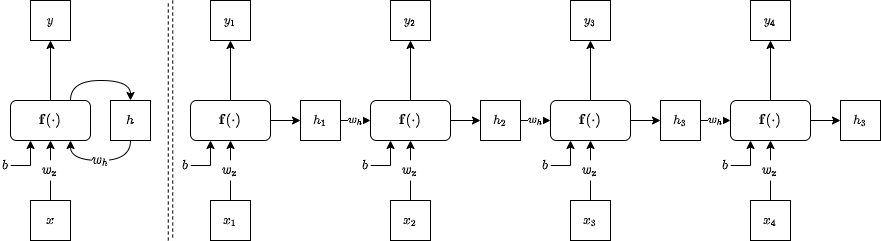

The above figure shows how RNN works. The left is a simple representation of the RNN perceptron (or *memory cell*). First, the cell receives two inputs: a regular input, $x$, and the previous *hidden state*, $h$. Then, it puts out two types of outputs, a regular output, $y$, and *hidden state*, $h$.

If you unroll the left figure, you can understand the structure of the RNN more clearly. At each time step $t$, the cell receives $x_t$ and $h_{t-1}$ and puts out $y_t$ and $h_t$.

Then, let's implement this RNN in Keras.

In [ ]:
from tensorflow import keras


model = keras.models.Sequential([
    keras.layers.SimpleRNN(
        units = 1,
        input_shape=(None, 1)
    )
])

model.summary()


As shown above, our RNN has three parameters:
* A weight for the input
* A weight for the hidden state
* A bias

What if we consider the larger dimensional inputs with specific time steps and the larger number of cells? Suppose we have 2 RNN cells and 3-D inputs are collected for 4 time steps.

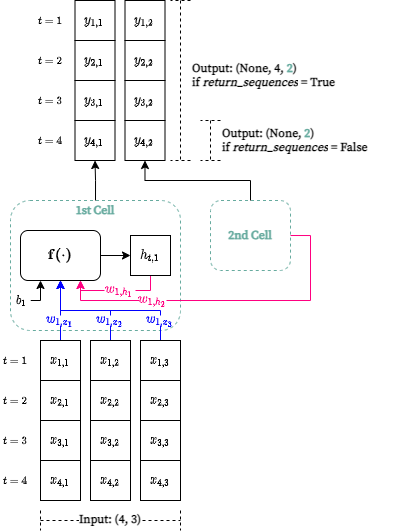

As shown above, this layer puts outs 4-D outputs, in which each RNN cell puts out an output. In addition, each RNN cell receives all inputs and all hidden states.

The important note is that you can choose whether the RNN layer gives outputs as sequences or not using the argument, "return_sequences." If you want a sequence output, the RNN layer gives multiple rows of outputs, in which the number of rows is equal to the input length (or time steps). If not, it provides the last output.

Let's implement this!

In [ ]:
from tensorflow import keras


print('# return_sequences = False')
print(
    keras.models.Sequential([
        keras.layers.SimpleRNN(
            units = 2,
            input_shape=(4, 3),
            return_sequences=False
        )
    ]).summary()
)

print('# return_sequences = True')
print(
    keras.models.Sequential([
        keras.layers.SimpleRNN(
            units = 2,
            input_shape=(4, 3),
            return_sequences=True
        )
    ]).summary()
)

As shown above, both RNN layer have 12 trainable parameters: 2 (# cells) x 8 (3 weights for inputs + 2 weights for hidden states + 1 bias).
In addition, the layer whose *return_sequences = True* gives a sequence output whose length is equal to the input length (i.e., 4).

Also, Keras provides an alternative way for defining the RNN with *cells*, as below:

In [ ]:
from tensorflow import keras


keras.models.Sequential([
    # Call keras.layers.RNN instead of keras.layers.SimpleRNN
    keras.layers.RNN(
        # And, here we define "cell"
        cell = keras.layers.SimpleRNNCell(
            units = 2
        ),
        input_shape=(4, 3),
        return_sequences=True
    )
]).summary()

What are the differences between the two ways of implementing the RNN? While the first (i.e., *keras.layers.SimpleRNN*) is simple and optimized for GPU use, it does not support a customized RNN cell. On the other hand, the second way is slightly cumbersome to write and is not optimized for the GPU. However, we can put a custom RNN cell there (we will show it later).


#### Types of RNN
As you expected in the previous example, the RNN can give different forms of outputs, like a vector vs. a sequence. Here, we will cover a variety of RNNs considering inputs and outputs.

##### Sequence-to-Vector Network

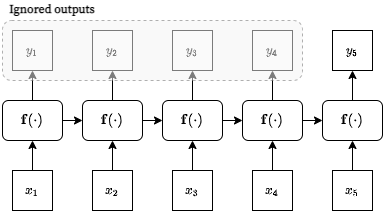

*The sequence-to-vector network* gives a vector output from a sequence input (like, *return_sequences = False*). For example, you could feed the network with a sequence of words corresponding to a movie review, and the network would output a sentiment score (e.g., -1: hate to +1: love).


##### Sequence-to-Sequence Network

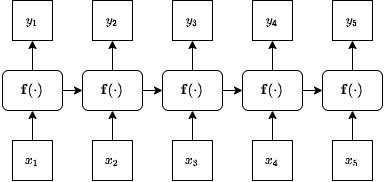

Of course, the RNN can give a sequence output from a sequence input (like, *return_sequences = True*). This network helps predict time series such as stock prices: you feed it with the prices over the last N days, and it outputs the prices shifted by one day into the future.

##### Vector-to-Sequence Network

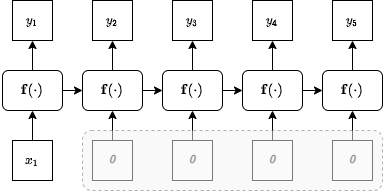

Surprisingly, the RNN can use a vector as input and put out a sequence as output. The representative example is a description of the image: input could be an image, and the output could be a short sentence that describes the image.

##### Encoder-Decoder


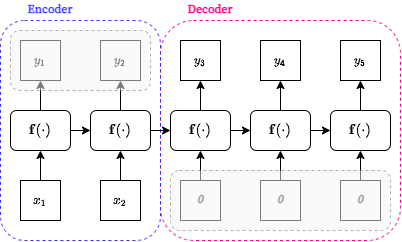

Lastly, you may merge two networks: one is a sequence-to-vector network, called *an encoder*, and the other is a vector-to-sequence network, called  *a  decoder*. For example, this could be used for translating a sentence from one language to another. If you first input a sentence in one language, the encoder converts this sentence into a single vector representation. Then, the decoder would decode this vector into a sentence in another language.

Why do we just translate a sequence of one language into a sequence of another language using the sequence-to-sequence network? Actually, the whole words of a sentence are highly correlated. Therefore, the network needs to wait until the whole sentence comes in for a more correct translation.

#### Problems with Training Long Sequences
As you learned, the RNN is devised to handle sequences. However, the vanilla RNN does not work well, especially in handling long sequences. From now, we will cover the shortcomings of the vanilla RNN and how to complement them.

##### Exploding/Unstable Gradients
As we briefly covered in the previous lecture on the DNN, gradient descent may also malfunction in the RNN. In practice, the gradient often grows larger and larger so that the RNN cannot find the optimal parameter. This phenomenon is called the *exploding gradient*. Why does such a problem occur? Let's see how backpropagation works in the RNN.

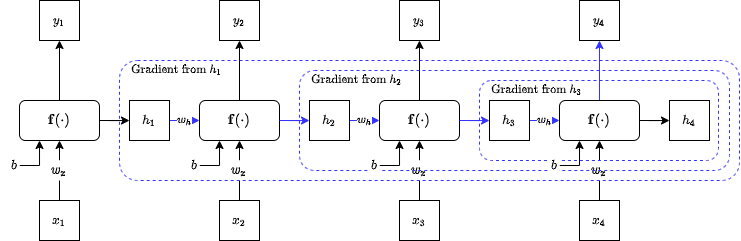

The figure above is an unrolled architecture of the RNN. The regular neural network has several weight parameters corresponding to inputs. However, *the RNN shares parameters*. Therefore, the loss gradient with respect to a given weight is roughly *the sum of all gradients from previous time steps*. As a result, the gradient would be highly likely to grow.

###### Gradient Clipping
As we learned in the previous lecture, the most straightforward way to prevent the gradient become larger is to *clip the gradient so that they never exceed a particular threshold*, as below.

In [ ]:
from tensorflow import keras

'''Gradients should be within [-1.0, 1.0]'''
model = keras.models.Sequential()
model.compile(
    optimizer=keras.optimizers.SGD(
        clipvalue=1.0
    )
)

###### Using Saturating Activating Function
Another technique to prevent exploding gradient is to *use saturating function*. It is surprising, right? While the DNN uses *a non-saturating function* (e.g., Leaky ReLU, SELU, ELU, etc.) for addressing vanishing gradient, the RNN needs to use the saturating function!

|Leaky ReLU|tanh|sigmoid|
|--|--|--|
|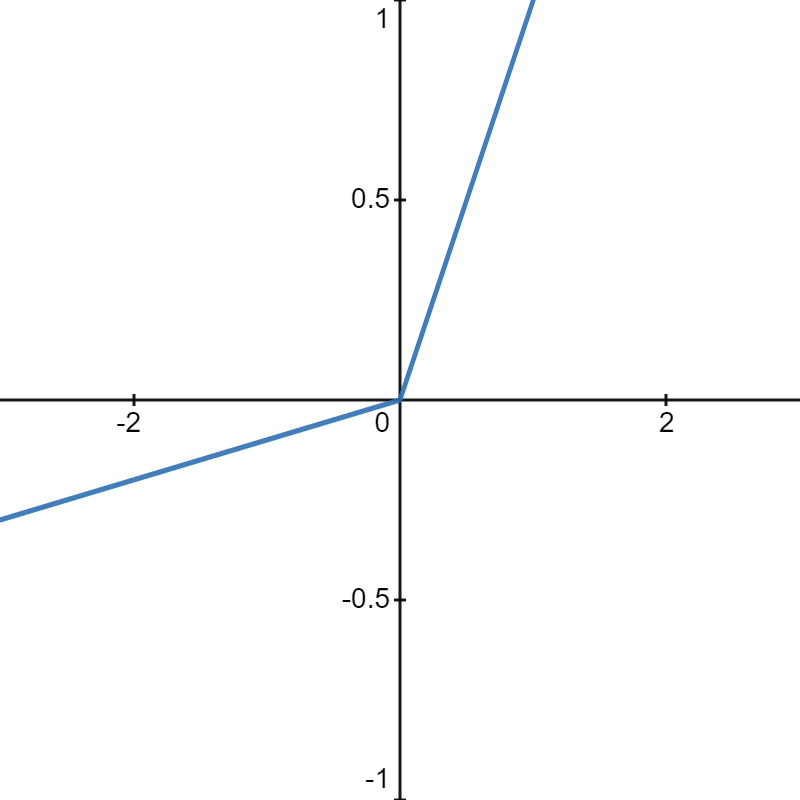|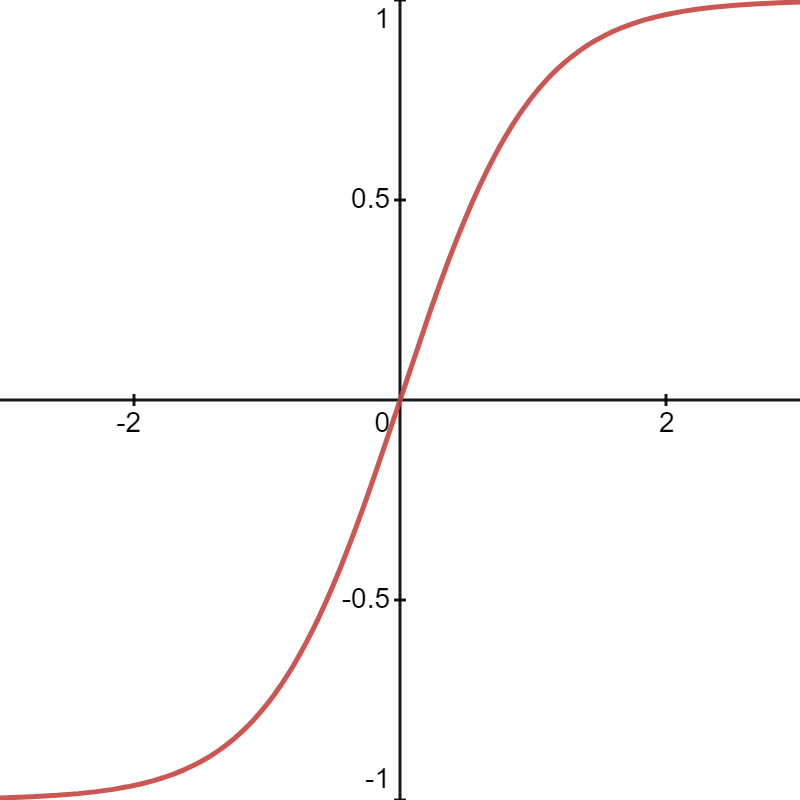|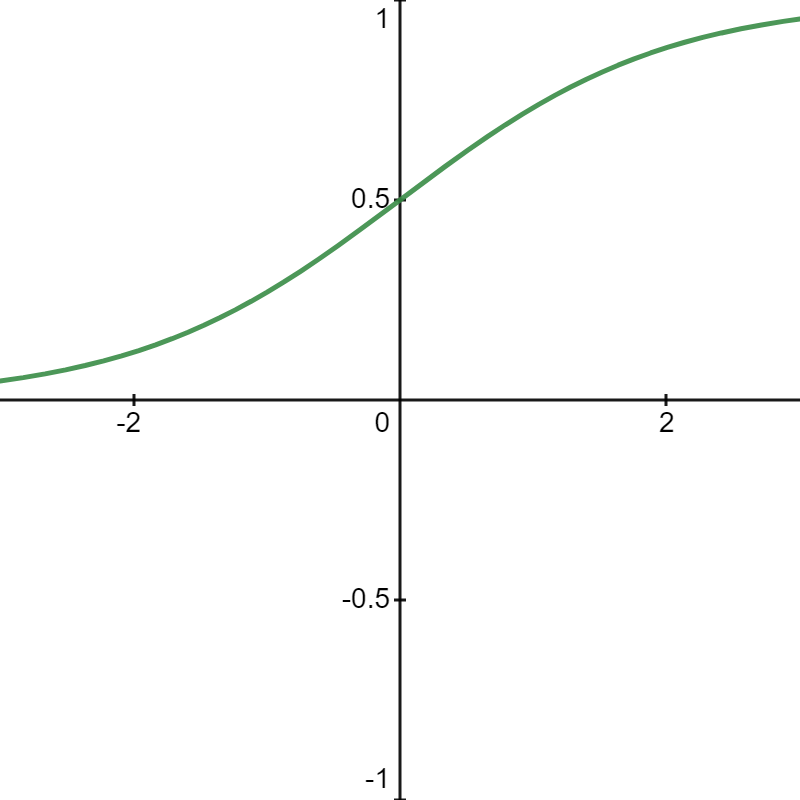|

For example, the Leaky ReLU has no point that the gradient becomes zero (although there is the non-differentiable point at 0). What about saturating functions such as sigmoid or hyperbolic tangent (tanh) function? We can clearly see such a function has some points where the gradient becomes extremely close to zero. Therefore, saturating function can prevent the gradient from significantly growing.

Actually, the Keras' default implementation for the RNN uses the hyperbolic tangent as an activation function:

```python
tf.keras.layers.SimpleRNN(
    units,
    activation='tanh', # Hyperbolic Tangent
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    **kwargs
)
```



###### Layer Normalization
As we covered in the previous lecture, *batch normalization* normalizes and rescales one batch of inputs to reduce the risk of unstable gradients in the DNN. Is it possible to use batch normalization in the RNN? It may not. As we learned, batch normalization is *the layer that standardizes inputs*. Therefore, if you want to apply batch normalization in the RNN, you have to *put different batch normalization layers between unrolled cells*, as below.

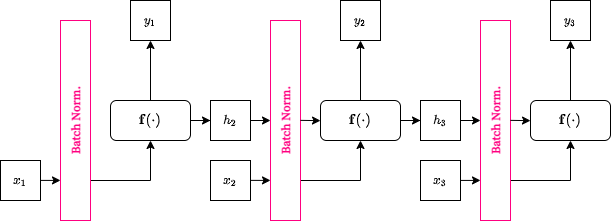

Although it seems complicated to implement, researchers tried it. Unfortunately, [it does not work well](https://arxiv.org/abs/1510.01378). It was found that the batch normalization in the RNN is slightly beneficial only when it was applied to the inputs, not between unrolled cells.

Instead, RNN uses a different type of normalization: *Layer Normalization*. While batch normalization considers a batch of each input (e.g., rows of a single column in tabular data), layer normalization considers the feature dimension (e.g., a single row of columns in tabular data). It seems weird, but actually, it works.

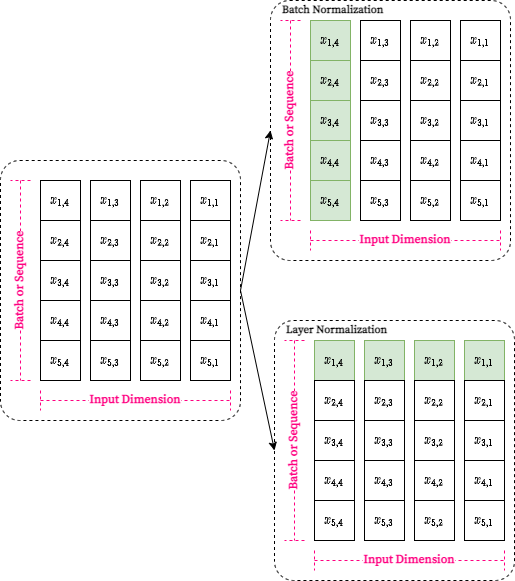

The RNN with the layer normalization works differently from the batch normalization:
$$ h_{\mathbf{w}, b, \gamma, \beta} (\mathbf{x}) = \phi(\gamma \frac{\mathbf{w}^\intercal \mathbf{x} - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta) + b$$
where
* $\phi$: Activation function for the RNN cell
* $ \mu $: Mean of *feature dimension* ($\mathbf{w}^\intercal \mathbf{x}$)
* $ \sigma $: Variance of *feature dimension* ($\mathbf{w}^\intercal \mathbf{x}$)
* $ \gamma $: Rescaling parameter
* $ \beta $: Offset
* $\epsilon$: Hyperparameter for preventing zero-division

While the batch normalization maintains $\mu$ and $\sigma$ to calculate the final mean and variance for test set prediction, the layer normalization calculates these values at each time step. Therefore, it does not need to hold them for training.

To apply the layer normalization in Keras, we need an additional package, [tensorflow_addons](https://www.tensorflow.org/addons), which provides extra functionality for TensorFlow.

In [ ]:
from tensorflow import keras
import tensorflow_addons as tfa


model = keras.models.Sequential([
    keras.layers.RNN(
        # Here, SimpleRNNCell with layer normalization
        cell = tfa.rnn.LayerNormSimpleRNNCell(
            units = 4
        ),
        input_shape=(None, 3)
    )
])

model.summary()

As shown above, we have 36 trainable parameters: 4 (# cells) x 9 (3 weights for inputs + 4 weights for hidden states + 1 bias + 1 $\gamma$).

Wait? where is the $\beta$? As the equation shows, $\beta$ will become something (like $\beta'$) via an activation function. If you add $\beta'$ into the RNN cell's bias, $b$, you can get a new bias, $b'$. Then, you need to train $b'$ only, not both $\beta$ and $b$. This is an optimization technique applied to the *LayerNormSimpleRNNCell*.

Anyway, we do not have any non-trainable parameters in this model, right?


##### Vanishing Early Inputs

Another problem of the vanilla RNN for handling long sequences is that it does not contain any trace of early inputs. Suppose we translate very long sentences. When the input sentence ends, the RNN may forget what the first word is. We need to remember something that informs the network of how the sentence is started. In other words, we want to allow the RNN to have *a long-term memory*. The representative technique for the long-term memory cell is the *Long Short-Term Memory (LSTM)*.

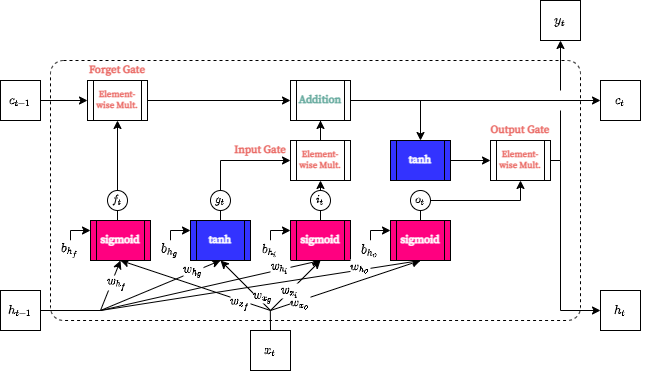

The figure above shows the architecture of the LSTM cell. It looks pretty complicated. Don't worry. We will not cover all details of the LSTM because this course is not deep learning. Instead, we will briefly look over the main ideas of the LSTM cell.

As shown above, the LSTM has two hidden states: the long-term state, $c_t$, and the short-term state, $h_t$. The long-term state, $c_t$, first goes through a *forget gate* to drop some memories. Then, new memories (i.e., inputs, $x_t$, and the short-term state, $h_t$) from *input gate* are added to the $c_t$.

On the other hand, the short-term state, $h_t$, goes through an *output gate*, building the new short-term state, which is composed of the new long-term state, the previous short-term state, and the new inputs. The output of the LSTM state is equal to the new short-term state.

Then, it's time to build the LSTM layer using Keras.

In [ ]:
from tensorflow import keras


model = keras.models.Sequential([
    keras.layers.LSTM(
        units = 4,
        input_shape=(4, 3),
    )
])

model.summary()

Of course, you can alternatively build an LSTM model using *keras.layers.LSTMCell*.

In [ ]:
from tensorflow import keras


model = keras.models.Sequential([
    keras.layers.RNN(
        cell=keras.layers.LSTMCell(
            units = 4,
        ),
        input_shape=(4, 3),
    )
])

model.summary()

Either way, we have 128 parameters that should be optimized: 4 (# cells) x 32 (4 weights for an input x 3-D input + 4 weights for the short-term state x 4 perceptrons + 4 biases)

If you want to apply the layer normalization to the LSTM, then you need to use *tensorflow_addons*, as below:

In [ ]:
from tensorflow import keras
import tensorflow_addons as tfa

model = keras.models.Sequential([
    keras.layers.RNN(
        cell=tfa.rnn.LayerNormLSTMCell(
            units = 4,
        ),
        input_shape=(4, 3),
    )
])

model.summary()

In the layer-normalized LSTM, we have additonally 72 parameters, 4 (# cells) x 2 ($\gamma$ and $\beta$) x 9 ($ \mathbf{w_{x_{f}}}^\intercal \mathbf{x_t}$, $ \mathbf{w_{x_{g}}}^\intercal \mathbf{x_t}$, $ \mathbf{w_{x_{i}}}^\intercal \mathbf{x_t}$, $ \mathbf{w_{x_{o}}}^\intercal \mathbf{x_t}$, $ \mathbf{w_{h_{f}}}^\intercal \mathbf{h_t}$, $ \mathbf{w_{h_{g}}}^\intercal \mathbf{h_t}$, $ \mathbf{w_{h_{i}}}^\intercal \mathbf{h_t}$, $ \mathbf{w_{h_{o}}}^\intercal \mathbf{h_t}$, and $\mathbf{c}_t$). Note that different from the layer-normalized RNN, we use both $\gamma$ and $\beta$, because each cell has only one bias.

## Practice: Classifying Different Physical Activities using CNN and RNN

That's all for theory. Now, we will build actual CNN and RNN models.

### Data: UCI's Smartphone-Based Recognition of Human Activities and Postural Transitions (HAPT) Data Set


HAPT dataset is built from the sensor recordings of 30 subjects who perform basic physical activities. The activities are:
* Static postures: standing, sitting, lying
* Dynamic activities: walking, walking downstairs, and walking upstairs.
* Transition: stand-to-sit, sit-to-stand, sit-to-lie, lie-to-sit, stand-to-lie, and lie-to-stand.

All the participants wore a smartphone (Samsung Galaxy S II) on their waist. 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz using the embedded accelerometer and gyroscope of the device.

The video below shows the data collection setting.

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('XOEN9W05_4A', width=1000, height=800)

In [ ]:
from urllib.request import urlopen
import pickle
import numpy as np


URL = 'https://drive.google.com/uc?export=download&id=15mVbcvxP2-Lhs9H-ayOclftHWxp8lIyo'

DATASET = pickle.load(urlopen(URL))

X = DATASET['X']
y = DATASET['y']
PIDS = DATASET['pid']
LABELS = DATASET['labels']
COLUMNS = DATASET["columns"]


print(f'Columns: {COLUMNS}')
print(f'Data shape: X={X.shape}; y={y.shape}; pid={PIDS.shape}')
print(f'Label: \r\n{LABELS}')
print(f'Label dist.: \r\n{np.unique(y, return_counts=True)}')

Let's visualize this data for participant #1.

In [ ]:
from itertools import product
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np


fig = make_subplots(
    rows=6, cols=1, shared_xaxes=True, shared_yaxes=False,
    row_titles=COLUMNS
)

M_p1 = PIDS == 1
X_p1 = X[M_p1]
y_p1 = y[M_p1]
t = np.arange(X_p1.shape[0])

for i, c in enumerate(COLUMNS):
    for j in np.unique(y_p1):
        label = LABELS[j]
        M_t = y_p1 == j
        t_j = t[M_t]
        x = X_p1[M_t, i]

        fig.add_trace(
            go.Scatter(x=t_j, y=x, mode='markers', name=label, showlegend=False, marker=dict(size=2)),
            row=(i+1), col=1,
        )

fig.update_layout(
    width=1000,
    height=1000
)

fig.show()


As shown in the plots above, 3-axial sensor data clearly shows directional characteristics of physical activities. However, we want other data that show trends independent of the direction. For this, we put additional data, *the magnitude of 3-axial values*, into the original data:
$$ \text{magnitude} = \sqrt{x^2 + y^2 + z^2} $$

In [ ]:
import numpy as np

X_w_mag = np.concatenate(
    (
        # Original data
        X,
        # Mag. of 3-axial acceleration values
        np.sqrt(np.sum(np.square(X[:, 0:3]), axis=1)).reshape(-1, 1),
        # Mag. of 3-axial gyroscope values
        np.sqrt(np.sum(np.square(X[:, 3:6]), axis=1)).reshape(-1, 1)
    ), axis=1
)

X_w_mag.shape

### Preparation: 2-D Vector Input to 3-D Vector Input

Because human beings' physical activities are performed over time, we cannot predict them using a single shot of sensor data. Instead, we will predict activities using a window of inputs across several time steps. For example, suppose we want to build a model that classifies physical activities every 1 second using 2-seconds data (i.e., a 2-second time window with a 1-second slide). Then, each window contains *100 (2-second x 50Hz) samples* with sliding by 50 samples (1-second x 50Hz), in which each sample has 8 values (3-axial accelerometer/gyroscope and their magnitudes).

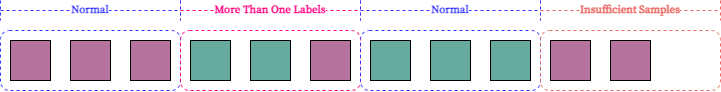


Unfortunately, if we divide the entire data into 2-second windows, there may exist *some boundary windows where two or more activities are performed*. In addition, *some windows may have samples smaller than 100*. We will exclude such data. Moreover, in this practice, we focus on *physical activity labels (i.e., standing, sitting, lying, walking, walking downstairs, and walking upstairs)*, not transition.


In [ ]:
import numpy as np


WIN_SIZE = 100 # Window Size
SLIDE_SIZE = 50 # Slide Size

X_prep, y_prep, PIDS_prep = [], [], []

for pid in np.unique(PIDS):
    '''Subset a given participant's data'''
    M = PIDS == pid
    X_p, y_p, pid_p = X_w_mag[M, :], y[M], PIDS[M]

    '''250 samples for each bulk'''
    for t in np.arange(WIN_SIZE, M.shape[0], SLIDE_SIZE):
        X_t, y_t, pid_t = X_p[(t - WIN_SIZE):t, :], y_p[(t - WIN_SIZE):t], pid_p[(t - WIN_SIZE):t]

        # Check wheter the number of samples is insufficient
        if X_t.shape[0] < WIN_SIZE:
            continue

        # Check whether all labels are same
        if np.sum(y_t == y_t[0]) != WIN_SIZE:
            continue

        # Check whether it is an activity label.
        if y_t[0] > 5:
            continue

        X_prep.append(X_t)
        y_prep.append(y_t[0])
        PIDS_prep.append(pid)

X_prep = np.asarray(X_prep)
y_prep = np.asarray(y_prep)
PIDS_prep = np.asarray(PIDS_prep)

print(f"X's shape: {X_prep.shape}")
print(f"y's shape: {y_prep.shape}")
print(f"pid's shape: {PIDS_prep.shape}")

Then, we split the entire data into a train and test set. Participants #1 - #25 will be used for training, and other data will be used as test sets.

In [ ]:
M_train = PIDS_prep <= 25
X_train, y_train = X_prep[M_train, :, :], y_prep[M_train]
X_test, y_test = X_prep[~M_train, :, :], y_prep[~M_train]

### Building and Training

#### Convolution Neural Network

First, we will build the CNN as below:

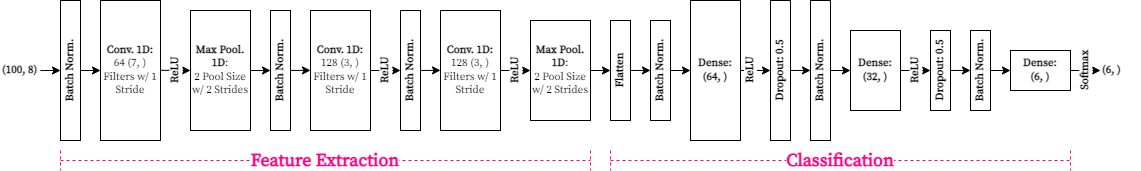

In [ ]:
from tensorflow import keras


model_cnn = keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape = (100, 8)),
    keras.layers.Conv1D(
        filters=64, kernel_size=7, padding = "same",
        activation = keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.MaxPooling1D(
        pool_size=2
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(
        filters=128, kernel_size=3, padding = "same",
        activation = keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(
        filters=128, kernel_size=3, padding = "same",
        activation = keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.MaxPooling1D(
        pool_size=2
    ),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(
        units = 64,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.Dropout(
        rate=0.5
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(
        units = 32,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.Dropout(
        rate=0.5
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(
        units = 6,
        activation=keras.activations.softmax,
        kernel_initializer=keras.initializers.GlorotUniform(seed=42),
    )
])

print(f'# Summary: \r\n{model_cnn.summary()}')

model_cnn.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[
            keras.metrics.SparseCategoricalAccuracy(),
    ]
)

model_cnn.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=25
)



#### Long Short-Term Memory
Of course, we will also build the LSTM.

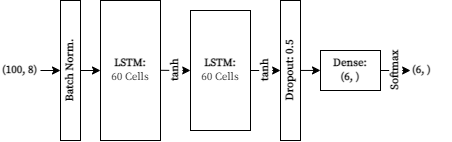

In [ ]:
from tensorflow import keras


model_lstm = keras.models.Sequential([
    keras.layers.BatchNormalization(
        input_shape=(100, 8)
    ),
    keras.layers.LSTM(
        units=60,
        activation=keras.activations.tanh,
        kernel_initializer=keras.initializers.GlorotNormal(seed=42),
        return_sequences=True
    ),
    keras.layers.LSTM(
        units=60,
        activation=keras.activations.tanh,
        kernel_initializer=keras.initializers.GlorotNormal(seed=42),
        return_sequences=False
    ),
    keras.layers.Dropout(
        rate=0.5
    ),
    keras.layers.Dense(
        units = 6,
        activation=keras.activations.softmax,
        kernel_initializer=keras.initializers.GlorotUniform(seed=42)
    )
])

print(f'# Summary: \r\n{model_lstm.summary()}')

model_lstm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[
            keras.metrics.SparseCategoricalAccuracy(),
    ]
)

model_lstm.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=25
)

#### ConvLSTM: Convolution + LSTM
Wait, what if we connect the convolution layers and LSTM layers? We may let the convolution layer extract features and the LSTM do classification. Let's merge the two networks we previously built.

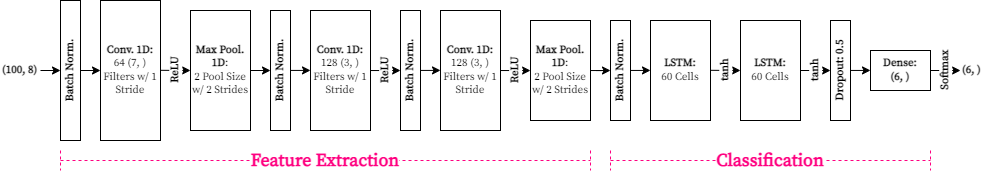

In [ ]:
from tensorflow import keras


model_convlstm = keras.models.Sequential([
    # Convolution layers
    keras.layers.BatchNormalization(input_shape = (100, 8)),
    keras.layers.Conv1D(
        filters=64, kernel_size=7, padding = "same",
        activation = keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.MaxPooling1D(
        pool_size=2
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(
        filters=128, kernel_size=3, padding = "same",
        activation = keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(
        filters=128, kernel_size=3, padding = "same",
        activation = keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.MaxPooling1D(
        pool_size=2
    ),
    # LSTM
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(
        units=60,
        activation=keras.activations.tanh,
        kernel_initializer=keras.initializers.GlorotNormal(seed=42),
        return_sequences=True
    ),
    keras.layers.LSTM(
        units=60,
        activation=keras.activations.tanh,
        kernel_initializer=keras.initializers.GlorotNormal(seed=42),
        return_sequences=False
    ),
    keras.layers.Dropout(
        rate=0.5
    ),
    keras.layers.Dense(
        units = 6,
        activation=keras.activations.softmax,
        kernel_initializer=keras.initializers.GlorotUniform(seed=42)
    )
])

print(f'# Summary: \r\n{model_convlstm.summary()}')

model_convlstm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[
            keras.metrics.SparseCategoricalAccuracy(),
    ]
)

model_convlstm.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=25
)

### Evaluation

In [ ]:
print('# CNN Performance: \r\n - Cross-entropy: {0[0]:2f} \r\n - Accuracy: {0[1]:2f}'.format(
    model_cnn.evaluate(X_test, y_test))
)
print('# LSTM Performance: \r\n - Cross-entropy: {0[0]:2f} \r\n - Accuracy: {0[1]:2f}'.format(
    model_lstm.evaluate(X_test, y_test))
)
print('# ConvLSTM Performance: \r\n - Cross-entropy: {0[0]:2f} \r\n - Accuracy: {0[1]:2f}'.format(
    model_convlstm.evaluate(X_test, y_test))
)

## Homework: Classifying Physical Activities using Different Dataset

In HAPT dataset, sensor data are collected from a waist-mounted smartphone. In this homework, we will use sensor data that are collected in a slightly different setting: the smartphone is in the trousers' front pocket.


### Dataset: [MotionSense](https://www.kaggle.com/datasets/malekzadeh/motionsense-dataset)
Mohammad Malekzadeh, Richard G. Clegg, Andrea Cavallaro, and Hamed Haddadi. 2018. Protecting Sensory Data against Sensitive Inferences. In Proceedings of the 1st Workshop on Privacy by Design in Distributed Systems (W-P2DS'18). Association for Computing Machinery, New York, NY, USA, Article 2, 1–6. https://doi.org/10.1145/3195258.3195260

This dataset includes time-series data generated by *accelerometer and gyroscope sensors (attitude, gravity, userAcceleration, and rotationRate) at 50Hz* and participants' characteristics (e.g., weight, age, etc.) It is collected with an iPhone 6s kept in the participant's front pocket using SensingKit, which collects information from Core Motion framework on iOS devices.

Originally, 24 participants performed 6 activities: *downstairs, upstairs, walking, jogging, sitting, and standing*. However, we will cover only 10 participants for this homework due to size issues.


In [ ]:
from urllib.request import urlopen
import pickle
import numpy as np


URL = 'https://drive.google.com/uc?export=download&id=16GnTmuktaJy20_a12giTVB7smsjALQNH'

DATASET = pickle.load(urlopen(URL))

X = DATASET['X']
y = DATASET['y']
PIDS = DATASET['pid']
LABELS = DATASET['labels']
COLUMNS = DATASET["columns"]


print(f'Columns: {COLUMNS}')
print(f'Data shape: X={X.shape}; y={y.shape}; pid={PIDS.shape}')
print(f'Label: \r\n{LABELS}')
print(f'Label dist.: \r\n{np.unique(y, return_counts=True)}')
print(f'Participant.: \r\n{np.unique(PIDS)}')

### Instruction
* You will receive 3 points in total.
* Prepare data
    * Add magnitude values for 3-axial sensor data
        * attitude.role/pitch/yaw
        * gravity.x/y/z
        * rotationRate.x/y/z
        * userAcceleration.x/y/z
    * Exclude time-invariant data, *weight, height, age, gender*.
    * Our network will receive sensor recordings within a 1-second time window, in which the window slides by 0.5-second.
    * Each window should correspond to only one label and contain 50 samples.
* Build the ConvLSTM model as shown below.
    * Use the best weight intialization for each activation function
    * Use the logistic loss for the loss function
    * Use the Nadam optimizer and limit gradients within [-1.0, 1.0]
* Evaluate your model using leave-one-user-out cross-validation.
    * Measure the performance with cross-entropy and accuracy.
* You don't have to do learning rate scheduling and regularization.


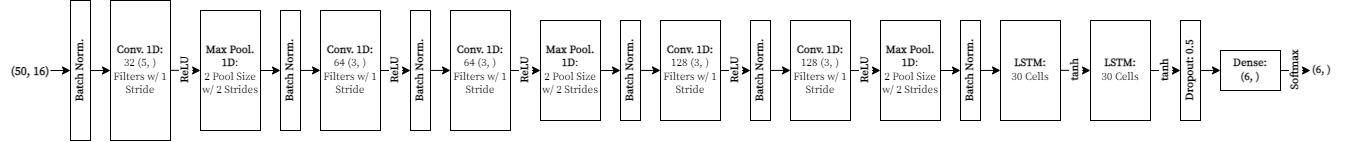

([Here](https://drive.google.com/file/d/16r4d2CGrTlqxCu5qeBWTpoP82CKH46Gs/view?usp=sharing) is the bigger size of the figure above)



### Submission

In [ ]:
from tensorflow import keras
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut


METRICS = []


'''------ Begin: Add Magnitude Values for 3-Axial Data (0.25 pt) ------'''

########################### YOUR CODES HERE ###########################

'''------ End: Add Magnitude Values for 3-Axial Data (0.25 pt) ------'''

'''------ Begin: Exclude Time-Invariant Data (0.25 pt) ------'''
''' "weight", "height", "age", "gender" '''

########################### YOUR CODES HERE ###########################

'''------ End: Exclude Time-Invariant Data (0.25 pt) ------'''


'''------ Begin: Preprocess Data (0.5 pt) ------'''
'''
   - Split entire data into 1-second window with 0.5-second sliding
   - Exclude windows that have more than one labels and have samples less than 50.
'''

########################### YOUR CODES HERE ###########################

'''------ End: Preprocess Data (0.5 pt) ------'''


'''------ Begin: Leave-One-User-Out CV (0.25 pt) ------'''

########################### YOUR CODES HERE ###########################

    '''------ End: Leave-One-User-Out CV (0.25 pt) ------'''

    fold_name = np.unique(PIDS_prep[I_test])[0]

    '''------------ Begin: Building ConvLSTM model (1.25 pt) ------------'''

    ########################### YOUR CODES HERE ###########################

    '''------------ End: Building ConvLSTM model (1.25 pt) ------------'''

    '''------- Begin: Loss Function and Optimizer (0.25 pt) -------'''

    ########################### YOUR CODES HERE ###########################

    '''-------- End: Loss Function and Optimizer (0.25 pt) --------'''

    model.fit(
        x=X_train,
        y=y_train,
        batch_size=64,
        epochs=5
    )

    '''----- Begin: Calculate Performance Measures (0.25 pt) -----'''

    ########################### YOUR CODES HERE ###########################

    '''------ End: Calculate Performance Measures (0.25 pt) ------'''

    METRICS.append({
        'Fold': fold_name,
        'Cross-Entropy': cross_entropy,
        'Accuracy': accuracy
    })


If you do well, you will see boxplots for different performance measures and statistics (e.g., mean, standard deviation, and 95% confidence interval) using the codes below.

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
from plotly import graph_objects as go
from plotly.subplots import make_subplots


fig = make_subplots(rows=1, cols=2)

m_wide = pd.DataFrame(METRICS)
m_long = m_wide.melt(
    id_vars=['Fold'],
    var_name='metric',
    value_name='value'
)

for idx, metric in enumerate(m_long['metric'].unique()):
    fig.add_trace(
        go.Bar(x=m_long['Fold'], y=m_long.loc[lambda x: x['metric'] == metric, 'value'], name=metric),
        row=1, col=idx+1
    )

fig.show()

print(
    m_wide[['Cross-Entropy', 'Accuracy']].agg(
        lambda x: '{0:.3f} (SD: {1: .3f}); [{2[0]: .3f}, {2[1]: .3f}]'.format(
            np.mean(x),
            np.std(x, ddof=1),
            st.t.interval(0.95, len(x) - 1, loc=np.mean(x), scale=st.sem(x))
        )
    )
)